# Ch05 機器學習基礎

機器學習的基本問題就是優化和泛化之間的協調
優化是指調整模型使在訓練數據上獲得最佳性能的過程
泛化Generalize是指經過訓練的模型在其從未見過的數據上表現如何
當你過度優化模型後，過度擬合就會產生(模型過度執著與某一特徵，在訓練時獲得很好的效果，但在新數據上卻不能很好地找出訓練)


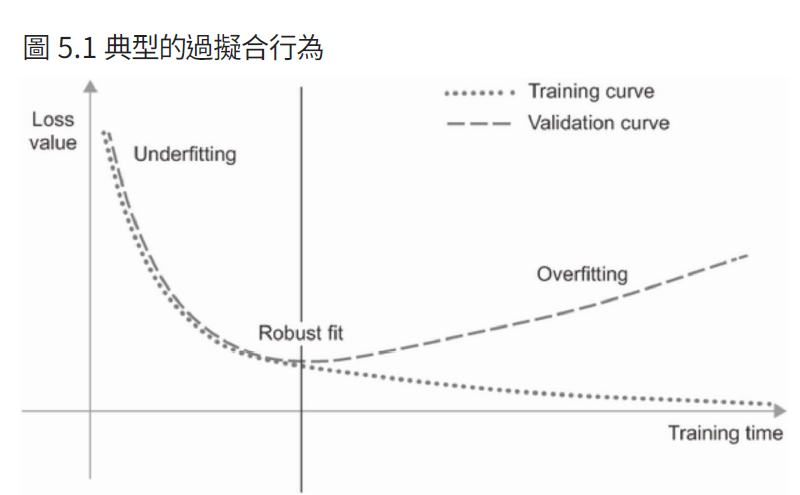

低度擬合underfitting:模型無法很好的找出資料與特徵之間的關係
過度擬合overfitting:模型在訓練資料中準確率很高，但卻無法應付測試資料

# 模稜兩可的特徵

並非所有的數據噪音都來自不準確，當問題涉及不確定性和模糊性時，即使是完全乾淨和整齊標記的數據也會產生噪音。
在進行分類認識時，經常會出現輸入特徵空間的某些區域同時與多個類相關聯的情況。
假設你正在開發一個模型，該模型拍攝香蕉的圖像並預測香蕉是未成熟、成熟還是腐爛的。
這些類別沒有客觀界線，所以同一張圖片可能會被不同的人分類為未成熟或成熟。
完全相同的測量結果有時可能會有不同的結果，這有一定的概率。
由於對特徵空間的模糊區域過於自信，模型可能會過度擬合此類概率。
Robust fit 將忽略單個數據點並著眼於更大的圖景。

接下來以MNIST數據為例，將784維的白噪音數據連接到現有數據來創建一個新的訓練集。
為了進行比較，可以同過連接784維全零數據，無意義的特徵不會影響分類的準確性。

# 創建加入白噪音和全零數據的新數據集

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

11501568/11490434 [==============================] - 0s 0us/step


# 訓練模型

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 7s 17ms/step - loss: 0.6195 - accuracy: 0.8120 - val_loss: 0.2562 - val_accuracy: 0.9222
Epoch 2/10
375/375 [==============================] - 6s 16ms/step - loss: 0.2509 - accuracy: 0.9225 - val_loss: 0.2176 - val_accuracy: 0.9331
Epoch 3/10
375/375 [==============================] - 6s 16ms/step - loss: 0.1631 - accuracy: 0.9489 - val_loss: 0.1468 - val_accuracy: 0.9557
Epoch 4/10
375/375 [==============================] - 6s 16ms/step - loss: 0.1147 - accuracy: 0.9643 - val_loss: 0.1345 - val_accuracy: 0.9625
Epoch 5/10
375/375 [==============================] - 7s 18ms/step - loss: 0.0837 - accuracy: 0.9735 - val_loss: 0.1440 - val_accuracy: 0.9597
Epoch 6/10
375/375 [==============================] - 6s 16ms/step - loss: 0.0613 - accuracy: 0.9806 - val_loss: 0.1512 - val_accuracy: 0.9573
Epoch 7/10
375/375 [==============================] - 6s 16ms/step - loss: 0.0454 - accuracy: 0.9854 - val_loss: 0.1162 - val_accuracy: 0.9675

# 繪製模型準確率隨時間演變

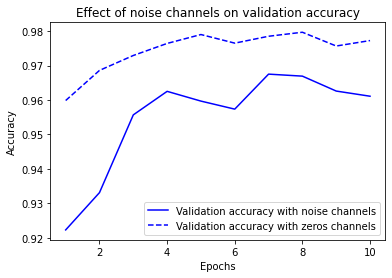

In [4]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

儘管含有相同的數據，使用白噪音的模型驗證準確率大概下降了1%，添加的白噪音越多，精度越會降低。

嘈雜的特徵不可避免地會導致過度擬合。因此，如果你不確定所擁有的特徵是提供信息還是分散注意力，通常會在訓練之前進行特徵選擇。
例如，將IMDB數據限制為前10,000個最常用的詞就是一種粗略的特徵選擇形式。
進行特徵選擇的典型方法是計算每個可用功能的一些有用性得分衡量特徵對於任務的信息量，例如特徵和特徵之間的交互訊息--並且只保留高於某個闕值的功能。
這樣做匯率除前面示例中的白噪音通道。


# 深度學習中泛化的本質

深度學習模型的一個顯著事實是，只要它們具有足夠的表徵能力，它們就可以北訓練以適應任何事物。

嘗試改組MNIST標籤並在此基礎上訓練模型。
儘管輸入和打亂標籤之間沒有任何關係，但訓練損失下降得很好，即使是相對較小的模型。
自然，驗證損失不會隨時間而改善，因為在這種情況下沒有泛化的可能性。

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 4s 10ms/step - loss: 2.3154 - accuracy: 0.1042 - val_loss: 2.3069 - val_accuracy: 0.1097
Epoch 2/100
375/375 [==============================] - 4s 9ms/step - loss: 2.2994 - accuracy: 0.1184 - val_loss: 2.3143 - val_accuracy: 0.1009
Epoch 3/100
375/375 [==============================] - 4s 9ms/step - loss: 2.2891 - accuracy: 0.1290 - val_loss: 2.3214 - val_accuracy: 0.1018
Epoch 4/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2747 - accuracy: 0.1441 - val_loss: 2.3254 - val_accuracy: 0.1028
Epoch 5/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2567 - accuracy: 0.1548 - val_loss: 2.3361 - val_accuracy: 0.1032
Epoch 6/100
375/375 [==============================] - 4s 9ms/step - loss: 2.2346 - accuracy: 0.1709 - val_loss: 2.3556 - val_accuracy: 0.1037
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2095 - accuracy: 0.1877 - val_loss: 2.3725 - val_accuracy: 0.

# 評估機器學習模型

評估模型可以歸納為將可用數據分成三組:訓練、驗證和測試。
在訓練數據上進行訓練並在驗證數據上評估你的模型。
一旦模型準備好，你將在測試數據上進行最後一次測試。

當可用數據很少時，有一些高級方法可以派上用場。
讓我們回顧一下三個經典的評估方法:簡單的保持驗證、K-fold驗證和帶有混洗的迭代K-fold驗證。
還會使用常識基線common-sense baselines去檢查訓練的進度。

## 1.簡單的保留驗證 simple holdout validation

將部分數據分開作為測試集。對剩餘數據進行訓練，並在測試集上進行評估。
為了防止資料外洩影響模型的泛化。
不應該根據測試集調整你的模型，因此你應該保留一個驗證集。

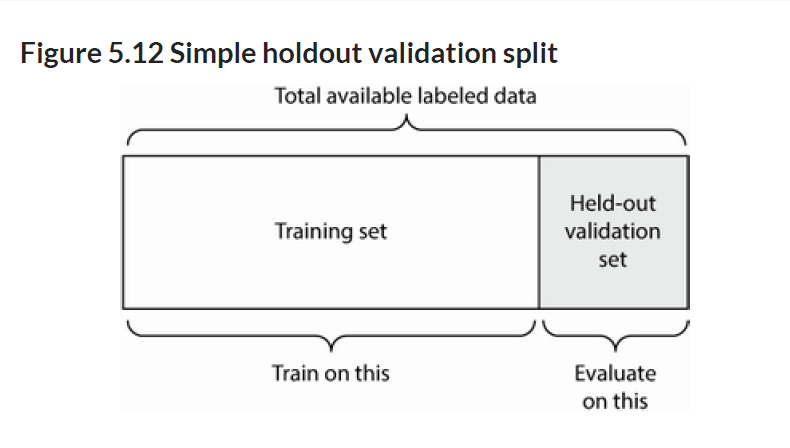

In [3]:
#holdout example
# import numpy as np
# num_validation_samples=10000

# np.random.shuffle(data)

# validation_data = data[:num_validation_samples]
# data = data[num_validation_samples:]

# training_data = data[:]

# model = get_model()
# model.train(training_data)
# validation_score = model.evaluate(validation_data)

# #At this point you can tune your model.
# #retrain it, evaluate it, tune it again...

# model = get_model()
# model.train(np.concatenate([training_data,
#               validation_data]))
# test_score = model.evaluate(test_data)

## 2.K-fold 驗證

將數據拆分為K個大小相等的分區，每次選出一區(i)，在剩餘K-1區上訓練模型，並對其進行評估，最終將得出的K分數平均。

# Iterated K-fold validation with shuffl ing

適用於數據相對較少的情況
在將數據拆分成K份之前，每次都對數據進行洗牌

# Beating a common-sense baseline 打破常識基線

訓練深度學習模型有點像是在平行世界中按下一個發射火箭的按鈕。你聽不見也看不到。你無法觀察到學習過程，他發生在一個有數千為的空間中，即使你將他投影到3D上，也無法解釋它。
你得到的為一反饋是你的驗證指標，就像是隱形火箭上的高度計。

在開始使用數據集之前，你應該選擇一個你將常識超越的微不足道的基線。
如果你越過了這個門檻，你就會知道你做對了。

當你開始解決以前沒有人解決過的問題時，擁有一個可以參考的常識基線是必不可少的。
如果你無法超越一個微不足道的解決方案，那麼你的模型就毫無價值，也許你使用了錯誤的模型，或者你正在解決的問題甚至無法通過機器學習來解決。

# 評估模型的注意事項

1.數據代表性，你的訓練集和測試集都能代表你的數據
假如你嘗試對數字圖像進行分類，並且從一個樣本數組開始，其中樣本按其類別排序，將數組的前80%作為你的訓練集，然後剩下的20%將只包含8-9類。訓練集將只包含0-7類。
出於這個原因，通常應該在將數據拆分為訓練集和測試集之前隨機打亂數據。

2.時間序列
如果想根據過去預測未來(例如明天的天氣、股票走勢等)，不應該在拆分數據之前隨機打亂你的數據，
應該確保測試集的所有數據都在訓練集中的數據之後。

3.多餘數據
如果數據中的某些數據點出現兩次(在實際數據中很常見)，那麼打亂數據並將其拆分為訓練集和驗證集將導致訓練集和驗證集之間出現冗餘。
確保你的訓練集和驗證集是不相交的

# 改進模型擬合

要達到完美擬合，必須先達到過擬合。
由於事先不知道邊界在哪裏，所以必須越過它才能找到它。
因此，當你開始解決一個問題時，你的初始目標是獲得一個顯示出某種泛化能力並且能夠過擬合的模型。
一旦你有了這樣的模型，你將專注於通過對抗過擬合來改進。

1.訓練沒有開始:訓練損失不會隨時間減少
2.訓練開始的很好，但模型沒有有意義的概括:你無法超越你設定的常識基線。
3.訓練和驗證損失都會隨時間下降，可以超過基線，但無法過擬合，這表示你仍然欠擬合。

## 調整關鍵梯度下降參數

有時訓練沒有開始或過早停止。
損失被卡住了

發生這種情況時，梯度下降過程的配置總是存在問題:你選擇的優化器、模型權重中初始值的分布、學習綠或批量大小。
所有參數都是相互依賴的，因此在保持其餘參數不變的同時調整學習綠和批量大小通常就足夠了。

下面使用MNIST模型，學習率為1

In [8]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 5s 11ms/step - loss: 2.3181 - accuracy: 0.1011 - val_loss: 2.3111 - val_accuracy: 0.1078
Epoch 2/100
375/375 [==============================] - 4s 10ms/step - loss: 2.3004 - accuracy: 0.1158 - val_loss: 2.3127 - val_accuracy: 0.1047
Epoch 3/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2896 - accuracy: 0.1284 - val_loss: 2.3228 - val_accuracy: 0.1032
Epoch 4/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2747 - accuracy: 0.1411 - val_loss: 2.3340 - val_accuracy: 0.0981
Epoch 5/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2553 - accuracy: 0.1561 - val_loss: 2.3442 - val_accuracy: 0.0988
Epoch 6/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2337 - accuracy: 0.1716 - val_loss: 2.3560 - val_accuracy: 0.1013
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 2.2092 - accuracy: 0.1882 - val_loss: 2.3668 - val_accuracy:

雖然效果不錯，但太耗時了
嘗試將批量降低並調整學習率

讓我們嘗試將學習率降低到更合理的值

In [9]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 6s 14ms/step - loss: 2.4468 - accuracy: 0.1068 - val_loss: 2.3021 - val_accuracy: 0.1104
Epoch 2/10
375/375 [==============================] - 5s 13ms/step - loss: 2.3033 - accuracy: 0.1105 - val_loss: 2.3033 - val_accuracy: 0.1088
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 2.3027 - accuracy: 0.1125 - val_loss: 2.3061 - val_accuracy: 0.1086
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 2.3025 - accuracy: 0.1130 - val_loss: 2.3052 - val_accuracy: 0.1025
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 2.3022 - accuracy: 0.1128 - val_loss: 2.3033 - val_accuracy: 0.1100
Epoch 6/10
375/375 [==============================] - 4s 10ms/step - loss: 2.3013 - accuracy: 0.1130 - val_loss: 2.3054 - val_accuracy: 0.1106
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 2.3007 - accuracy: 0.1129 - val_loss: 2.3035 - val_accuracy: 0.1098

## 利用更好的架構驗證

你有一個適合的模型，但由於某種原因，你的驗證指標根本沒有改善。
他們仍然不比隨機分類器實現的效果更好:
你的模型可以訓練但不能泛化。這是怎麼回事?

首先，你使用的輸入數據可能根本沒有包含足夠的訊息來預測你的目標:
公式中的問題是無法解決的。這就是我們之前嘗試擬合標籤被打亂的MNIST模型時發生的情況:
模型訓練得很好，但驗證準確率會停留在10%，因為用這樣的數據集進行泛化顯然是不可能的。

也可能是你使用的模型不適合手頭的問題。

## 增加模型容量

如果你設法找到了一個合適的模型，驗證指標正在下降，並且似乎至少達到了某種程度的泛化能力，那麼恭喜你快到了。
接下來，你需要讓你的模型開始過度擬合。

考慮以下在MNIST像素上訓練的小模型
一個簡單的邏輯回歸

In [12]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 2.3276 - accuracy: 0.1024 - val_loss: 2.3199 - val_accuracy: 0.1043
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 2.3115 - accuracy: 0.1087 - val_loss: 2.3215 - val_accuracy: 0.1028
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 2.3055 - accuracy: 0.1159 - val_loss: 2.3188 - val_accuracy: 0.1006
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 2.3013 - accuracy: 0.1179 - val_loss: 2.3266 - val_accuracy: 0.1027
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 2.2984 - accuracy: 0.1237 - val_loss: 2.3198 - val_accuracy: 0.1019
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 2.2961 - accuracy: 0.1225 - val_loss: 2.3253 - val_accuracy: 0.1070
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 2.2934 - accuracy: 0.1275 - val_loss: 2.3262 - val_accuracy: 0.1023
Epoch 

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


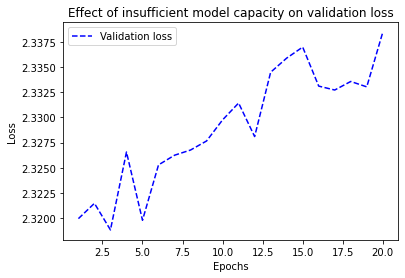

In [13]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

與上圖不同，當遇到損失無法再下降的情況時，可能是模型的表示能力存在問題:你將需要一個更大的模型，可以通過添加更多層、使用更大的層(具有更多參數的層)或使用更適合手頭問題的各種層(更好的架構)來提高表示能力。

讓我們嘗試訓練一個更大的模型，一個有兩個中間層，每個中間層有96個神經元

In [16]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 2.3065 - accuracy: 0.1048 - val_loss: 2.3039 - val_accuracy: 0.1072
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 2.3014 - accuracy: 0.1121 - val_loss: 2.3053 - val_accuracy: 0.1042
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 2.2986 - accuracy: 0.1155 - val_loss: 2.3066 - val_accuracy: 0.1065
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 2.2942 - accuracy: 0.1221 - val_loss: 2.3115 - val_accuracy: 0.1025
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 2.2884 - accuracy: 0.1281 - val_loss: 2.3165 - val_accuracy: 0.1071
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 2.2801 - accuracy: 0.1366 - val_loss: 2.3223 - val_accuracy: 0.1005
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 2.2705 - accuracy: 0.1456 - val_loss: 2.3232 - val_accuracy: 0.1036
Epoch 

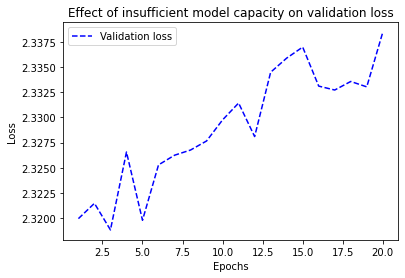

In [17]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 改進泛化

一旦你的模型顯示出自己具有一定的泛化能力並且能夠過擬合，就該將注意力轉移到最大化泛化上。

## 數據集管理

你已經了解到深度學習中的泛化源於數據的潛在結構。如果你的數據可以在樣本之間進行平滑插值，那麼你將能夠訓練一個泛化的深度學習模型。
如果你的問題過於嘈雜或根本上是離散的，例如列表排序，那麼深度學習將無濟於事。深度學習是曲線擬合，而不是魔法。

# 特徵工程

特徵工程是使用你對數據的知識和機器學習算法來使演算法工作更好。
期望機器學習模型能夠從完全任意的數據中學習是不合理的。

讓我們看一個直觀的例子。
假設你正在嘗試開發一個模型，該模型可以將時鐘圖像作為輸入並輸出一天鐘的時間

如果選擇使用圖像的原始像素作為輸入數據，你將面臨一個困難的機器學習問題。
你需要一個卷積神經網路來解決它，並且你必須花費相當多的計算資源

# 正則化

## 原始模型

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 52ms/step - loss: 0.5179 - accuracy: 0.7844 - val_loss: 0.4026 - val_accuracy: 0.8678
Epoch 2/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3109 - accuracy: 0.9045 - val_loss: 0.3032 - val_accuracy: 0.8908
Epoch 3/20
30/30 [==============================] - 1s 39ms/step - loss: 0.2251 - accuracy: 0.9284 - val_loss: 0.2792 - val_accuracy: 0.8945
Epoch 4/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1765 - accuracy: 0.9447 - val_loss: 0.3352 - val_accuracy: 0.8660
Epoch 5/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1453 - accuracy: 0.9552 - val_loss: 0.3033 - val_accuracy: 0.8822
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1162 - accuracy: 0.9652 - val_loss: 0.3013 - val_accuracy: 0.8862
Epoch 7/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1002 - accuracy: 0.9713 - val_loss: 0.3208 - val_accuracy: 0.8829
Epoch 8/20
30

## 容量較小的模型

In [4]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5970 - accuracy: 0.7571 - val_loss: 0.5033 - val_accuracy: 0.8446
Epoch 2/20
30/30 [==============================] - 1s 33ms/step - loss: 0.4388 - accuracy: 0.8777 - val_loss: 0.4103 - val_accuracy: 0.8652
Epoch 3/20
30/30 [==============================] - 1s 31ms/step - loss: 0.3500 - accuracy: 0.8971 - val_loss: 0.3528 - val_accuracy: 0.8767
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2905 - accuracy: 0.9127 - val_loss: 0.3176 - val_accuracy: 0.8838
Epoch 5/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2474 - accuracy: 0.9248 - val_loss: 0.2944 - val_accuracy: 0.8890
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2131 - accuracy: 0.9351 - val_loss: 0.2917 - val_accuracy: 0.8838
Epoch 7/20
30/30 [==============================] - 1s 46ms/step - loss: 0.1856 - accuracy: 0.9423 - val_loss: 0.2894 - val_accuracy: 0.8831
Epoch 8/20
30

# 繪製比較圖

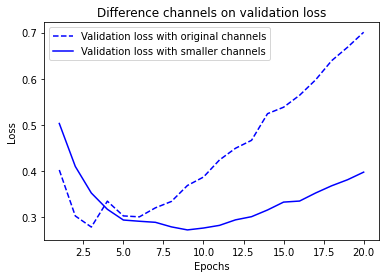

In [6]:
import matplotlib.pyplot as plt
val_loss_original = history_original.history["val_loss"]
val_loss_smaller = history_smaller_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss_original, "b--",
         label="Validation loss with original channels")
plt.plot(epochs, val_loss_smaller, "b-",
         label="Validation loss with smaller channels")
plt.title("Difference channels on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 較小的模型開始過擬合的時間比原始模型晚，而且一旦開始過擬合，其性能下降得更慢。

### 如果你的模型立即開始過度擬合，並且它的驗證損失曲線看起來不穩定且方差很大，你就會知道你的模型太大

## 容量較高的模型

In [7]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 10s 306ms/step - loss: 0.5597 - accuracy: 0.7601 - val_loss: 0.3068 - val_accuracy: 0.8832
Epoch 2/20
30/30 [==============================] - 9s 291ms/step - loss: 0.2587 - accuracy: 0.9017 - val_loss: 0.3046 - val_accuracy: 0.8800
Epoch 3/20
30/30 [==============================] - 9s 291ms/step - loss: 0.1633 - accuracy: 0.9409 - val_loss: 0.3538 - val_accuracy: 0.8663
Epoch 4/20
30/30 [==============================] - 9s 292ms/step - loss: 0.1043 - accuracy: 0.9669 - val_loss: 0.3725 - val_accuracy: 0.8828
Epoch 5/20
30/30 [==============================] - 9s 292ms/step - loss: 0.0256 - accuracy: 0.9939 - val_loss: 2.0471 - val_accuracy: 0.6619
Epoch 6/20
30/30 [==============================] - 9s 290ms/step - loss: 0.0363 - accuracy: 0.9906 - val_loss: 0.5072 - val_accuracy: 0.8844
Epoch 7/20
30/30 [==============================] - 9s 290ms/step - loss: 8.6888e-04 - accuracy: 0.9999 - val_loss: 0.6130 - val_accuracy: 0.8835
E

# 繪製比較圖

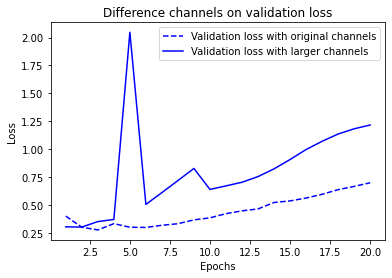

In [8]:
import matplotlib.pyplot as plt
val_loss_original = history_original.history["val_loss"]
val_loss_larger = history_larger_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss_original, "b--",
         label="Validation loss with original channels")
plt.plot(epochs, val_loss_larger, "b-",
         label="Validation loss with larger channels")
plt.title("Difference channels on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 添加權重正則化

通過強制其權重僅取較小的值來限制模型的複雜性

1. L1正則化:增加的成本與權重係數的絕對值成正比
2. L2正則化:增加的成本與權重係數的平方成正比，又稱權重衰減。

# 添加L2正則化到模型

In [9]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 50ms/step - loss: 0.5813 - accuracy: 0.7921 - val_loss: 0.4499 - val_accuracy: 0.8755
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.3908 - accuracy: 0.8979 - val_loss: 0.3885 - val_accuracy: 0.8828
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.3247 - accuracy: 0.9183 - val_loss: 0.3647 - val_accuracy: 0.8884
Epoch 4/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2962 - accuracy: 0.9245 - val_loss: 0.3685 - val_accuracy: 0.8807
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2763 - accuracy: 0.9337 - val_loss: 0.3562 - val_accuracy: 0.8882
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2614 - accuracy: 0.9384 - val_loss: 0.3825 - val_accuracy: 0.8785
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2547 - accuracy: 0.9411 - val_loss: 0.3659 - val_accuracy: 0.8851
Epoch 8/20
30

# 繪製比較圖

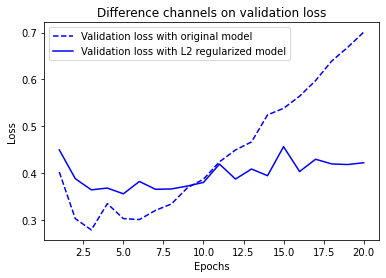

In [10]:
import matplotlib.pyplot as plt
val_loss_original = history_original.history["val_loss"]
val_loss_l2 = history_l2_reg.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss_original, "b--",
         label="Validation loss with original model")
plt.plot(epochs, val_loss_l2, "b-",
         label="Validation loss with L2 regularized model")
plt.title("Difference channels on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 由上圖可知，具有L2正則化的模型比原始模型更能抵抗過度擬合

# 作為L2正則化的替代方案，你可以使用以下Keras權重正則器之一。

In [11]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

# 請注意，權重正則化更常用於較小的深度學習模型。大型深度學習模型傾向於過度參數化，以至於對權重值施加約束對模型容量和泛化沒有太大的影響。在這些情況下，首選不同的正則化技術:dropout

# 向IMDB模型添加dropout

In [12]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 51ms/step - loss: 0.6342 - accuracy: 0.6336 - val_loss: 0.5366 - val_accuracy: 0.8494
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.5167 - accuracy: 0.7716 - val_loss: 0.4211 - val_accuracy: 0.8678
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.4333 - accuracy: 0.8363 - val_loss: 0.3493 - val_accuracy: 0.8830
Epoch 4/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3708 - accuracy: 0.8693 - val_loss: 0.3179 - val_accuracy: 0.8834
Epoch 5/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3201 - accuracy: 0.8942 - val_loss: 0.2957 - val_accuracy: 0.8873
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2808 - accuracy: 0.9123 - val_loss: 0.2805 - val_accuracy: 0.8934
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2483 - accuracy: 0.9241 - val_loss: 0.2862 - val_accuracy: 0.8938
Epoch 8/20
30

# 繪製比較圖

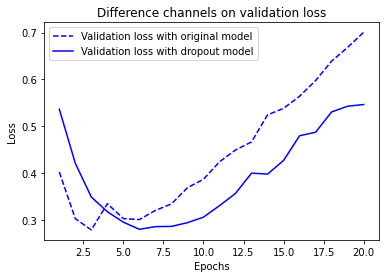

In [13]:
import matplotlib.pyplot as plt
val_loss_original = history_original.history["val_loss"]
val_loss_dropout = history_dropout.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss_original, "b--",
         label="Validation loss with original model")
plt.plot(epochs, val_loss_dropout, "b-",
         label="Validation loss with dropout model")
plt.title("Difference channels on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 看起來比L2正則化工作得更好，因為達到的最低驗證損失也得到了改善

# 回顧 - 最大化泛化和防止神經網路過度擬合的最常用方法

1.獲得更多的訓練數據或更好的訓練數據
2.開發更好的功能
3.減少模型的容量
4.添加權重正則化(對於較小的模型)
5.添加dropout

# Summary

1.深度學習網路通過學習可以在訓練樣本之間成功差值的參數模型來實現泛化，這樣的模型可以說是學習。
2.機器學習的根本問題是優化和泛化之間的張力，要實現泛化，必須首先實現對訓練數據的良好擬合，但是提高模型對訓練數據的擬合將不可避免地開始受到傷害。
3.開發模型時，必須能夠準確評估模型的泛化能力。從簡單的保留驗證到K-fold交叉驗證和迭代K-fold交叉驗證。
4.當你開始研究模型時，你的目標首先是獲得具有一定泛化能力並且可以過擬合的模型。這樣做的最佳實踐包含調整學習率和批量大小、利用更好的架構、增加模型容量。
5.當你的模型開始過度擬合時，你的目標會轉變為通過模型正則化來提高泛化能力。可以減少模型的容量、添加dropout或權重正則化，並使用提前停止。當然，更大或更好的數據集始終是幫助模型泛化的第一方法。